In [84]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation

In [85]:
# =============================================================================
# 1. LÓGICA MATEMÁTICA Y FÍSICA
# =============================================================================

G = 9.81
DT = 0.05

def F_tc(tc, D, h, v, phi_deg, T, u_max):
    phi_rad = np.deg2rad(phi_deg)
    den = tc - T
    if abs(den) < 1e-9: return 1e9
    
    ux = (D - (v * np.cos(phi_rad) * tc)) / den
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * G * (tc**2 - den**2)
    uy = (h + term2 - term3) / den
    return (ux**2 + uy**2) - u_max**2

def metodo_secante(D, h, v, phi_deg, T, u_max):
    t_prev, t_curr = T + 0.001, T + 2.0
    for _ in range(50):
        f_prev = F_tc(t_prev, D, h, v, phi_deg, T, u_max)
        f_curr = F_tc(t_curr, D, h, v, phi_deg, T, u_max)
        denom = f_curr - f_prev
        if abs(denom) < 1e-10: break
        t_next = t_curr - f_curr * ((t_curr - t_prev) / denom)
        if abs(t_next - t_curr) < 1e-5: return t_next
        t_prev, t_curr = t_curr, t_next
    return t_curr

def metodo_biseccion(D, h, v, phi_deg, T, u_max):
    a, b = T + 0.001, T + 5.0
    f_a = F_tc(a, D, h, v, phi_deg, T, u_max)
    for _ in range(100):
        c = (a + b) / 2
        f_c = F_tc(c, D, h, v, phi_deg, T, u_max)
        if f_a * f_c < 0: b = c
        else: a = c; f_a = f_c
        if abs(b - a) < 1e-5: return c
    return c

def generar_trayectorias(tc, D, h, v, phi_deg, T, C_arrastre, sigma_ruido):
    phi_rad = np.deg2rad(phi_deg)
    den = tc - T
    vx1_inic = - (v * np.cos(phi_rad))
    vy1_inic = v * np.sin(phi_rad)
    
    ux = (D - (v * np.cos(phi_rad) * tc)) / den
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * G * (tc**2 - den**2)
    uy = (h + term2 - term3) / den
    
    t = 0.0
    estado_p1 = np.array([D, h, vx1_inic, vy1_inic])
    estado_p2 = np.array([0.0, 0.0, ux, uy])
    
    hx1, hy1, hx2, hy2 = [], [], [], []
    
    while t < tc + 0.2:
        hx1.append(estado_p1[0]); hy1.append(estado_p1[1])
        hx2.append(estado_p2[0]); hy2.append(estado_p2[1])
        
        # P1
        v_mag1 = np.sqrt(estado_p1[2]**2 + estado_p1[3]**2)
        ax1 = -C_arrastre * v_mag1 * estado_p1[2]
        ay1 = -G - (C_arrastre * v_mag1 * estado_p1[3])
        estado_p1[0] += estado_p1[2] * DT
        estado_p1[1] += estado_p1[3] * DT
        estado_p1[2] += ax1 * DT + np.random.normal(0, sigma_ruido)
        estado_p1[3] += ay1 * DT + np.random.normal(0, sigma_ruido)
        
        # P2
        if t >= T:
            v_mag2 = np.sqrt(estado_p2[2]**2 + estado_p2[3]**2)
            ax2 = -C_arrastre * v_mag2 * estado_p2[2]
            ay2 = -G - (C_arrastre * v_mag2 * estado_p2[3])
            estado_p2[0] += estado_p2[2] * DT
            estado_p2[1] += estado_p2[3] * DT
            estado_p2[2] += ax2 * DT + np.random.normal(0, sigma_ruido)
            estado_p2[3] += ay2 * DT + np.random.normal(0, sigma_ruido)
        
        t += DT
        if estado_p1[1] < 0 and estado_p2[1] < 0: break
        
    return hx1, hy1, hx2, hy2, np.sqrt(ux**2+uy**2), np.degrees(np.arctan2(uy, ux))

In [86]:
# =============================================================================
# 2. INTERFAZ GRÁFICA PROFESIONAL
# =============================================================================

class AplicacionPro:
    def __init__(self, root):
        self.root = root
        self.root.title("Simulación Avanzada de Colisión de Proyectiles")
        self.root.geometry("1100x650")
        self.root.configure(bg="#f0f0f0")

        self.var_D = tk.DoubleVar(value=100.0)
        self.var_h = tk.DoubleVar(value=20.0)
        self.var_v = tk.DoubleVar(value=30.0)
        self.var_phi = tk.DoubleVar(value=45.0)
        self.var_T = tk.DoubleVar(value=1.0)
        self.var_umax = tk.DoubleVar(value=50.0)
        self.var_viento = tk.BooleanVar(value=False)
        self.metodo_sel = tk.StringVar(value="Secante")
        
        self.ani = None
        self.hx1, self.hy1, self.hx2, self.hy2 = [], [], [], []
        self.crear_layout()

    def crear_layout(self):
        panel_izq = tk.Frame(self.root, width=300, bg="#e0e0e0", padx=10, pady=10)
        panel_izq.pack(side=tk.LEFT, fill=tk.Y)
        
        estilo = {'bg': "#e0e0e0", 'font': ('Arial', 10)}
        
        # Inputs
        fp = tk.LabelFrame(panel_izq, text="Parámetros Iniciales P1", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fp.pack(fill=tk.X, pady=5, ipady=5)
        campos = [("Distancia D:", self.var_D), ("Altura h:", self.var_h), 
                  ("Velocidad v:", self.var_v), ("Ángulo φ:", self.var_phi),
                  ("Retraso T:", self.var_T), ("Potencia P2:", self.var_umax)]
        for i, (t, v) in enumerate(campos):
            tk.Label(fp, text=t, **estilo).grid(row=i, column=0, sticky='w', padx=5)
            tk.Entry(fp, textvariable=v, width=10).grid(row=i, column=1, padx=5)

        # Opciones
        fo = tk.LabelFrame(panel_izq, text="Opciones", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fo.pack(fill=tk.X, pady=10)
        tk.Checkbutton(fo, text="Viento (Ruido)", variable=self.var_viento, bg="#e0e0e0").pack(anchor='w', padx=10)
        tk.Radiobutton(fo, text="Método Secante", variable=self.metodo_sel, value="Secante", bg="#e0e0e0").pack(anchor='w', padx=10)
        tk.Radiobutton(fo, text="Método Bisección", variable=self.metodo_sel, value="Bisección", bg="#e0e0e0").pack(anchor='w', padx=10)
        
        tk.Button(fo, text="SIMULAR", bg="#4CAF50", fg="white", font=('Arial', 12, 'bold'), command=self.calcular).pack(fill=tk.X, padx=10, pady=10)

        # Resultados
        fr = tk.LabelFrame(panel_izq, text="Resultados", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fr.pack(fill=tk.X, pady=10)
        self.lbl_u = tk.Label(fr, text="u calc: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_u.pack()
        self.lbl_th = tk.Label(fr, text="θ calc: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_th.pack()
        self.lbl_tc = tk.Label(fr, text="T col: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_tc.pack()
        
        # Gráfica
        panel_der = tk.Frame(self.root, bg="white")
        panel_der.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        self.fig, self.ax = plt.subplots(dpi=100)
        self.canvas = FigureCanvasTkAgg(self.fig, master=panel_der)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def calcular(self):
        try:
            D, h, v = self.var_D.get(), self.var_h.get(), self.var_v.get()
            phi, T, umax = self.var_phi.get(), self.var_T.get(), self.var_umax.get()
            
            # Selección de método
            if self.metodo_sel.get() == "Secante":
                tc = metodo_secante(D, h, v, phi, T, umax)
            else:
                tc = metodo_biseccion(D, h, v, phi, T, umax)

            if tc > 50 or tc < T: raise ValueError("No converge")
            
            # Generar
            C = 0.001 if self.var_viento.get() else 0.0
            sigma = 0.05 if self.var_viento.get() else 0.0
            self.hx1, self.hy1, self.hx2, self.hy2, u_res, th_res = generar_trayectorias(tc, D, h, v, phi, T, C, sigma)
            
            self.lbl_u.config(text=f"u calc: {u_res:.2f} m/s")
            self.lbl_th.config(text=f"θ calc: {th_res:.2f}°")
            self.lbl_tc.config(text=f"T col: {tc:.2f} s")
            
            self.animar()
            
        except Exception as e:
            messagebox.showerror("Error", f"Error en cálculo: {e}")

    def animar(self):
        self.ax.clear()
        self.ax.grid(True, linestyle='--', alpha=0.6)
        
        # --- CÁLCULO DINÁMICO DE LÍMITES (LA CÁMARA SE AJUSTA SOLA) ---
        # 1. Buscamos la distancia horizontal máxima recorrida por cualquiera
        max_x_p1 = max(self.hx1) if len(self.hx1) > 0 else 0
        max_x_p2 = max(self.hx2) if len(self.hx2) > 0 else 0
        limite_x = max(max_x_p1, max_x_p2, self.var_D.get())
        
        # 2. Buscamos la altura máxima alcanzada
        max_y_p1 = max(self.hy1) if len(self.hy1) > 0 else 0
        max_y_p2 = max(self.hy2) if len(self.hy2) > 0 else 0
        limite_y = max(max_y_p1, max_y_p2, self.var_h.get())
        
        # 3. Aplicamos los límites con un margen del 10% para que se vea bonito
        self.ax.set_xlim(-10, limite_x * 1.1)
        self.ax.set_ylim(-5, limite_y * 1.2)
        
        self.ax.axhline(0, color='black')
        self.ax.set_xlabel("Distancia (m)")
        self.ax.set_ylabel("Altura (m)")
        
        # --- CREACIÓN DE ELEMENTOS GRÁFICOS ---
        self.linea1, = self.ax.plot([], [], 'r--', label='P1')
        self.punto1, = self.ax.plot([], [], 'ro')
        self.linea2, = self.ax.plot([], [], 'b-', label='P2')
        self.punto2, = self.ax.plot([], [], 'bo')
        self.colision, = self.ax.plot([], [], 'k*', markersize=15, visible=False, label='Colisión')
        self.ax.legend()
        
        def update(frame):
            # Proyectil 1
            self.linea1.set_data(self.hx1[:frame], self.hy1[:frame])
            self.punto1.set_data([self.hx1[frame]], [self.hy1[frame]])
            
            # Proyectil 2
            idx2 = min(frame, len(self.hx2)-1)
            # Solo dibujamos si el frame actual corresponde a movimiento de P2
            if frame < len(self.hx2):
                self.linea2.set_data(self.hx2[:idx2], self.hy2[:idx2])
                self.punto2.set_data([self.hx2[idx2]], [self.hy2[idx2]])
            
            # Estrella de Colisión (solo en el último frame)
            if frame == len(self.hx1) - 1:
                self.colision.set_data([self.hx2[-1]], [self.hy2[-1]])
                self.colision.set_visible(True)
                
            return self.linea1, self.punto1, self.linea2, self.punto2, self.colision

        # --- PROTECCIÓN CONTRA EL ERROR DE ANIMACIÓN ---
        if self.ani is not None:
            try:
                self.ani.event_source.stop()
            except AttributeError:
                pass 
        
        # Creamos la nueva animación
        self.ani = FuncAnimation(self.fig, update, frames=range(0, len(self.hx1), 2), 
                                 interval=20, blit=False, repeat=False)
        self.canvas.draw()

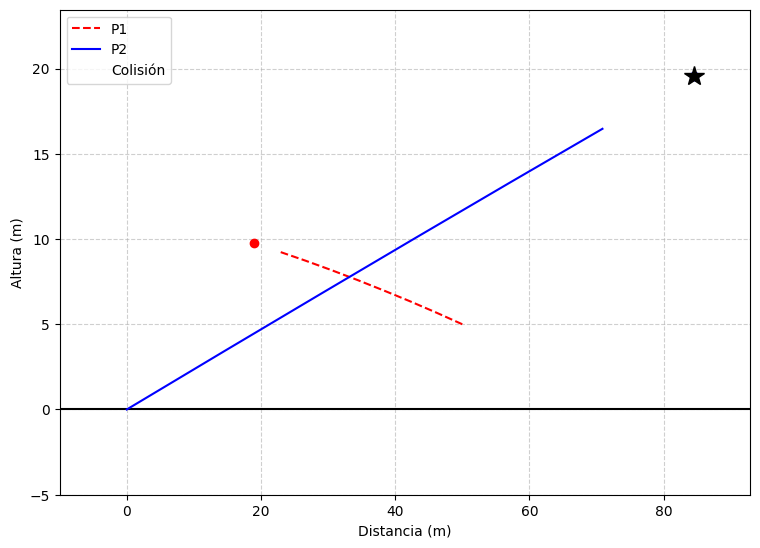

In [87]:
if __name__ == "__main__":
    root = tk.Tk()
    app = AplicacionPro(root)
    root.mainloop()